<a href="https://colab.research.google.com/github/wenchun0731/city-hunter/blob/main/crosswalk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
image=cv2.imread('/content/drive/MyDrive/Finetune/Licence_Finetune/FrameOutput/frame_0000.jpg')
image2=image.copy()


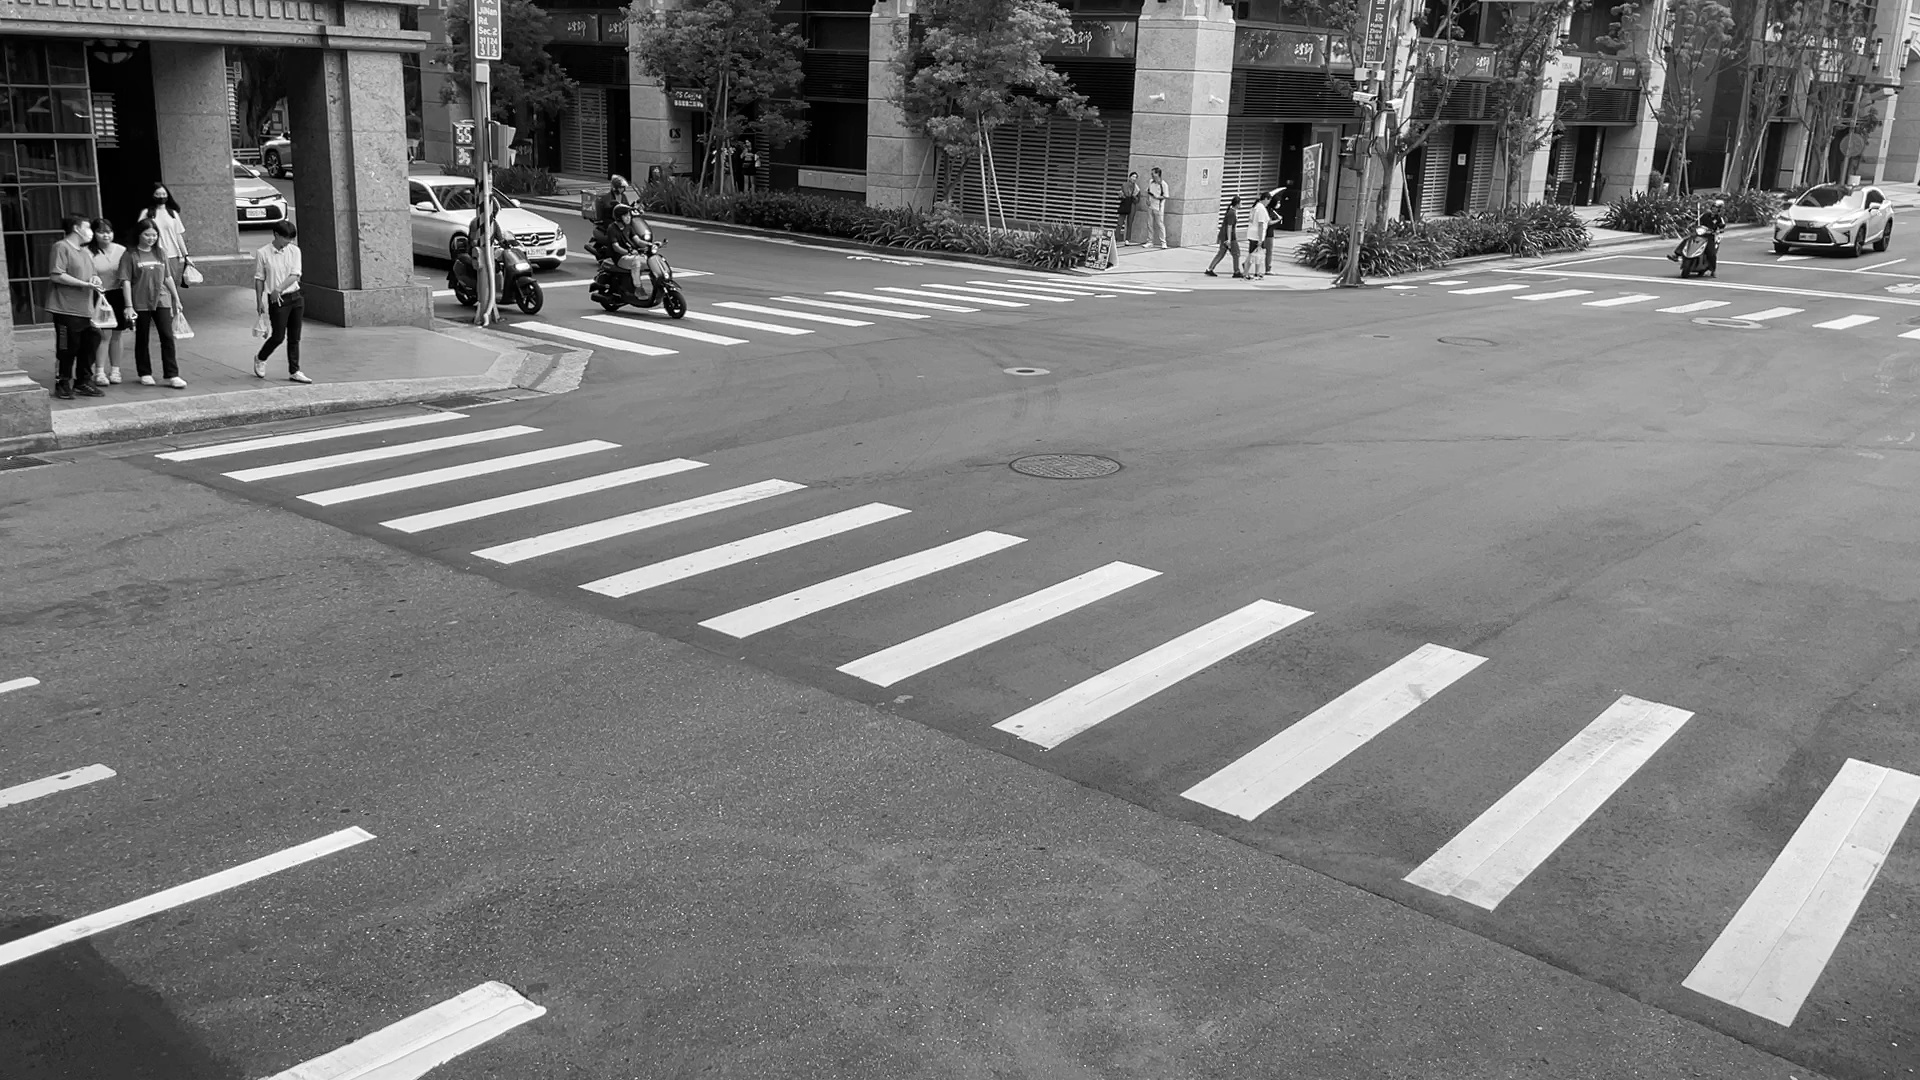

In [ ]:
gray_img = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
from google.colab.patches import cv2_imshow
cv2_imshow(gray_img)


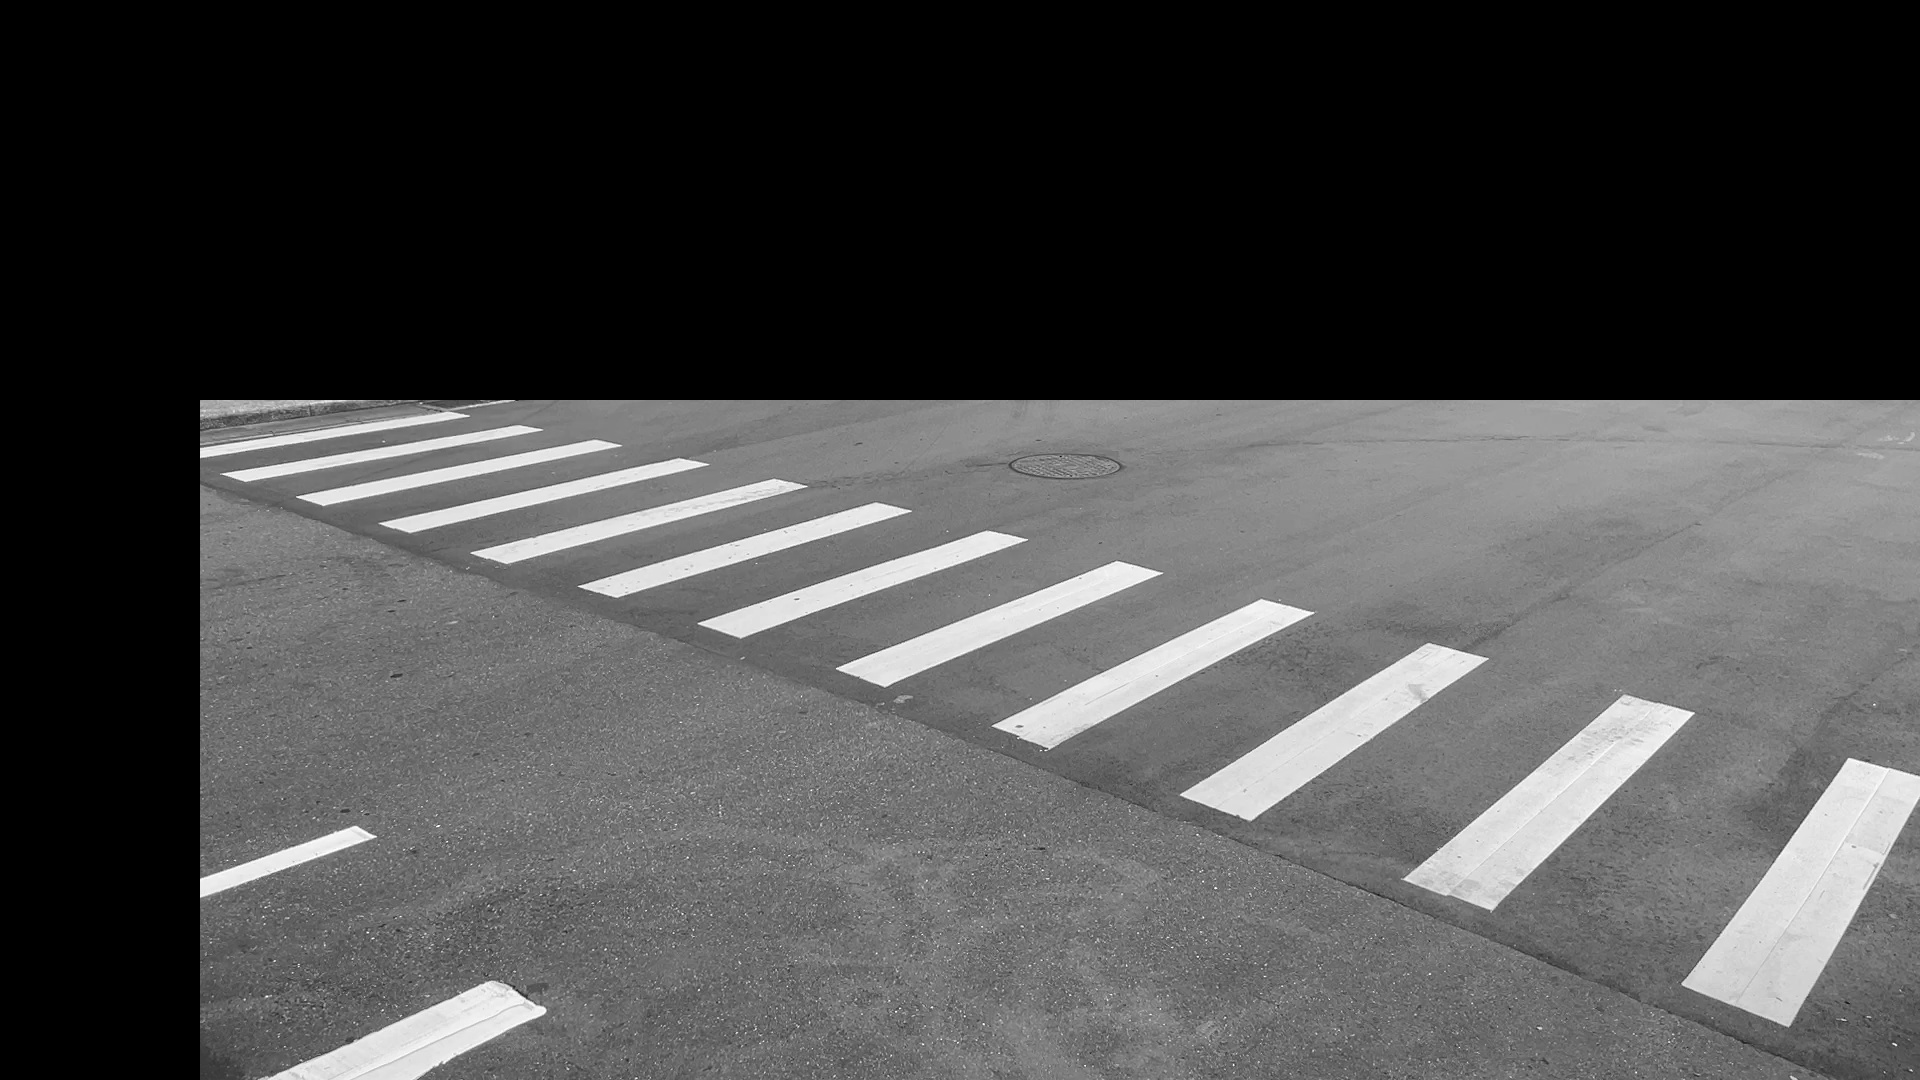

In [ ]:
import numpy as np

mask=np.ones_like(gray_img)*0
h,w=mask.shape[0:]
# print(h,w)
mask[400:h,200:w]=255
mask_edges=cv2.bitwise_and(gray_img,mask)
cv2_imshow(mask_edges)


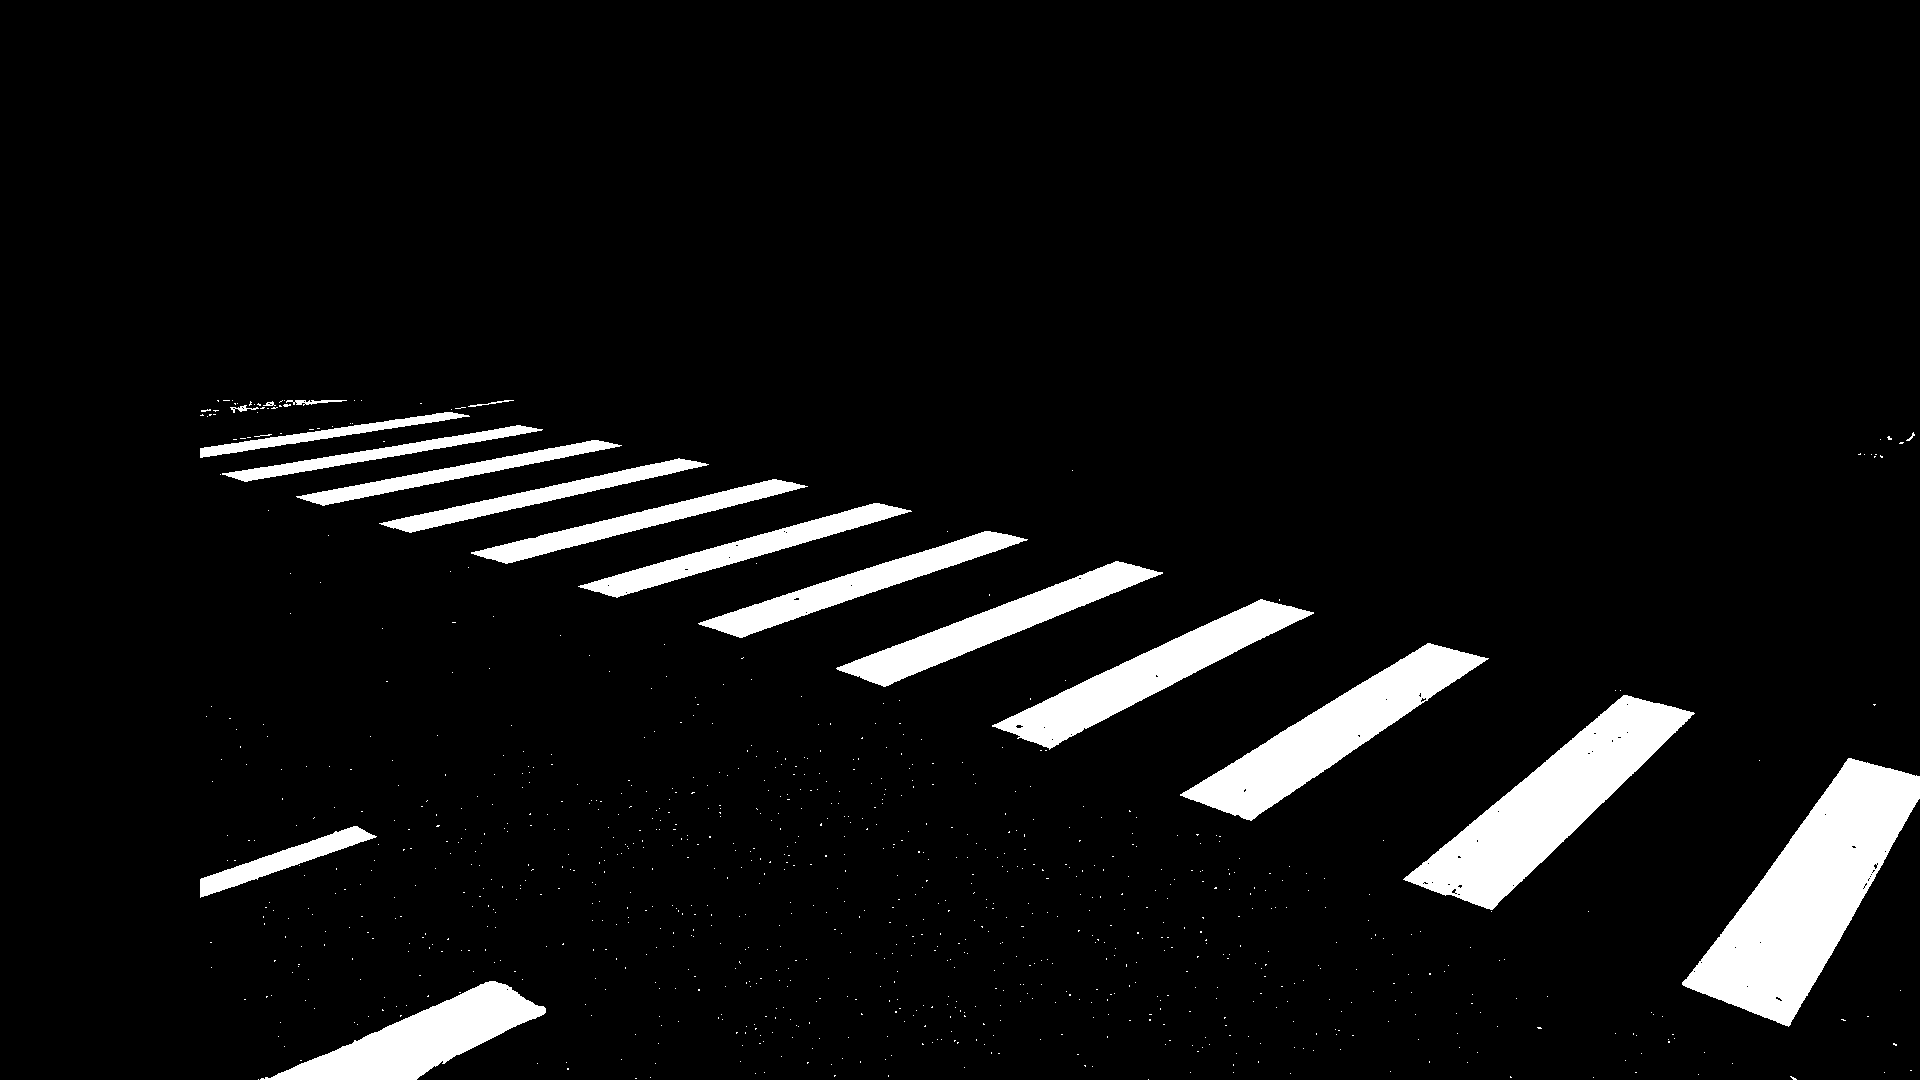

In [ ]:
threshold_value = 180  # 可以根據需要調整
max_value = 255
_, binary_image = cv2.threshold(mask_edges, threshold_value, max_value, cv2.THRESH_BINARY)
cv2_imshow(binary_image)


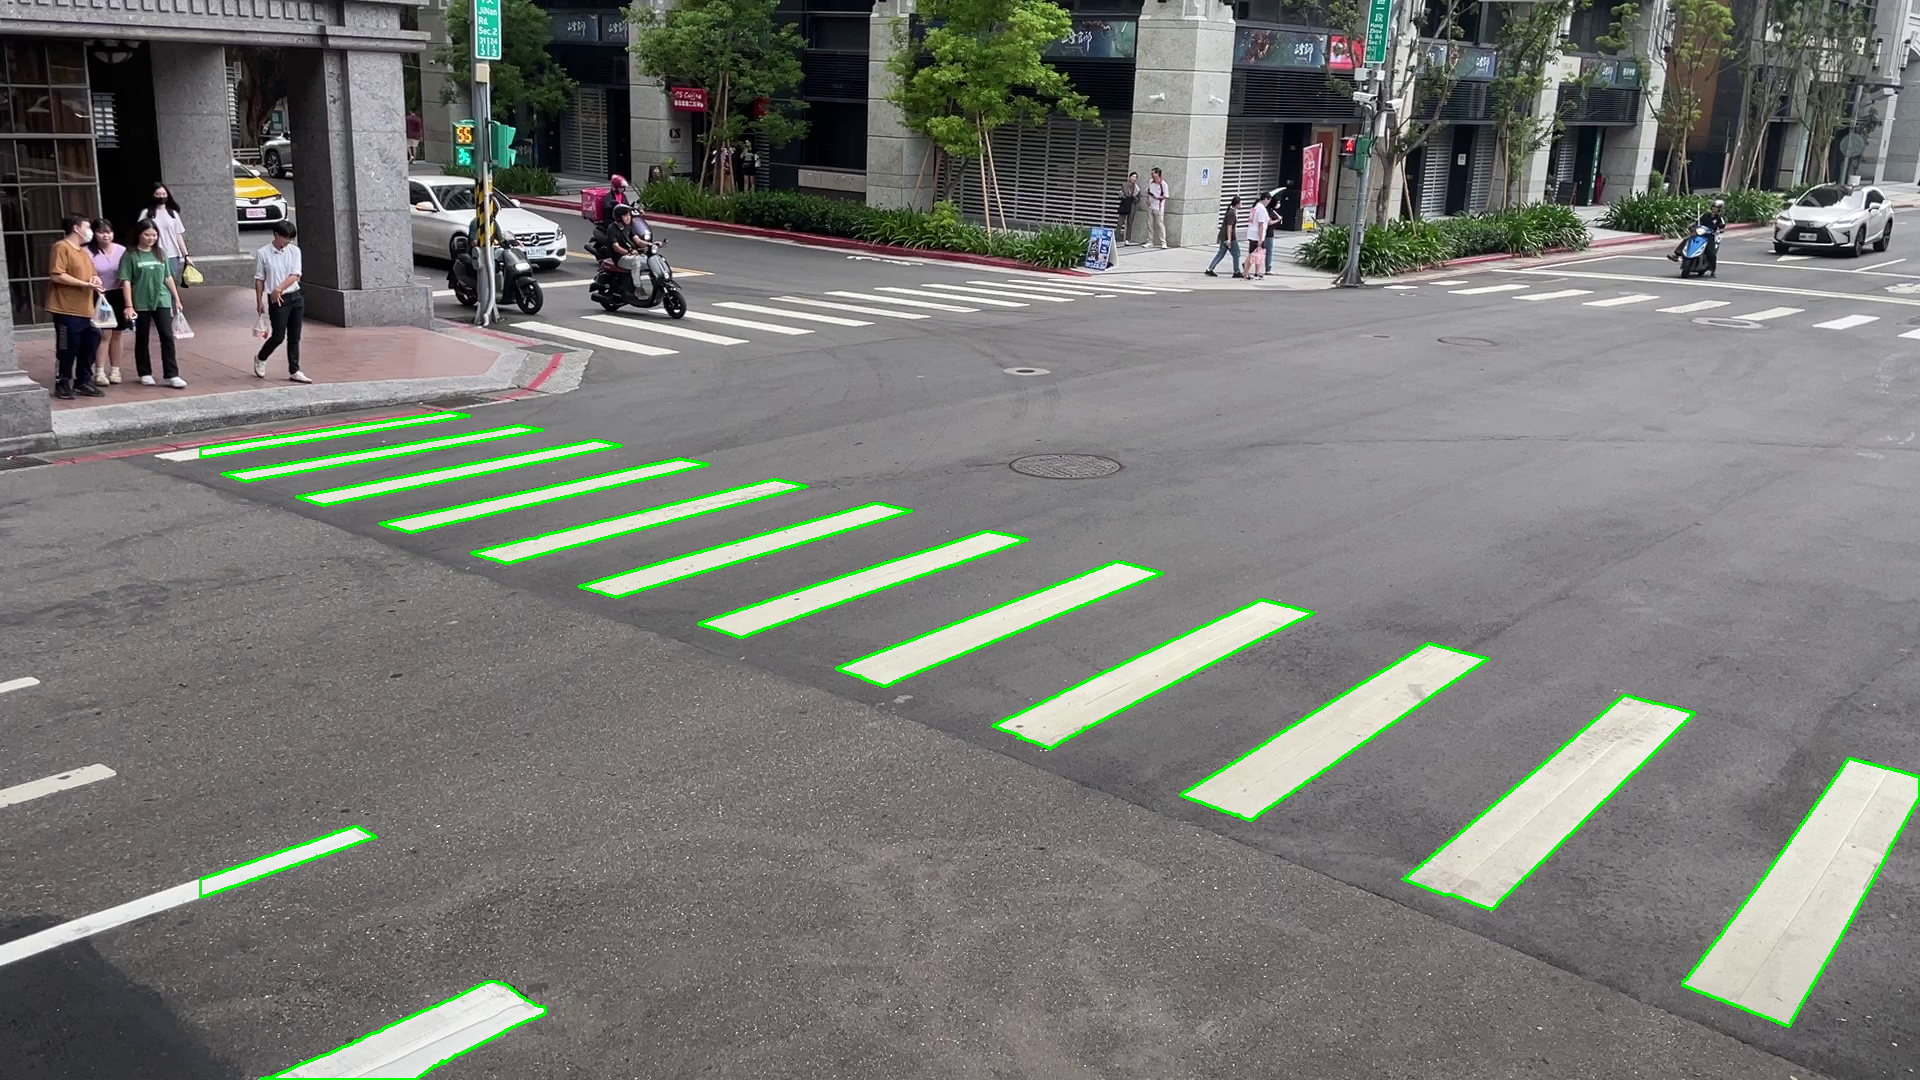

In [ ]:
contours, hierarchy = cv2.findContours(binary_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)


contour_all=[]

for contour in contours:
  area=cv2.contourArea(contour)
  if area>900:
    contour_all.append(contour)

cv2.drawContours(image, contour_all, -1, (0, 255, 0), 2)
# # 繪製輪廓
# if contour_all and len(contour_all) > 0:
#     cv2.drawContours(image, contour_all, -1, (0, 255, 0), 2)
# else:
#     print('沒有輪廓!!')
cv2_imshow(image)
image=image2.copy()


moments圖像矩:計算圖像的特徵量

M[m00]面積

M[m01]一階矩

423 1037
0.028724114896459586
282 859
0.1349206349206349
1808 894
1.6607142857142858
1548 803
0.7446236559139785
1330 732
0.5898305084745763
1147 673
0.5265200517464425
994 623
0.49352051835853133
857 584
0.4666039510818438
740 550
0.4491525423728814
633 521
0.43434343434343436
538 495
0.4232995658465991
452 472
0.4141689373297003
375 453
0.4058252427184466
323 434
0.4045084533500313


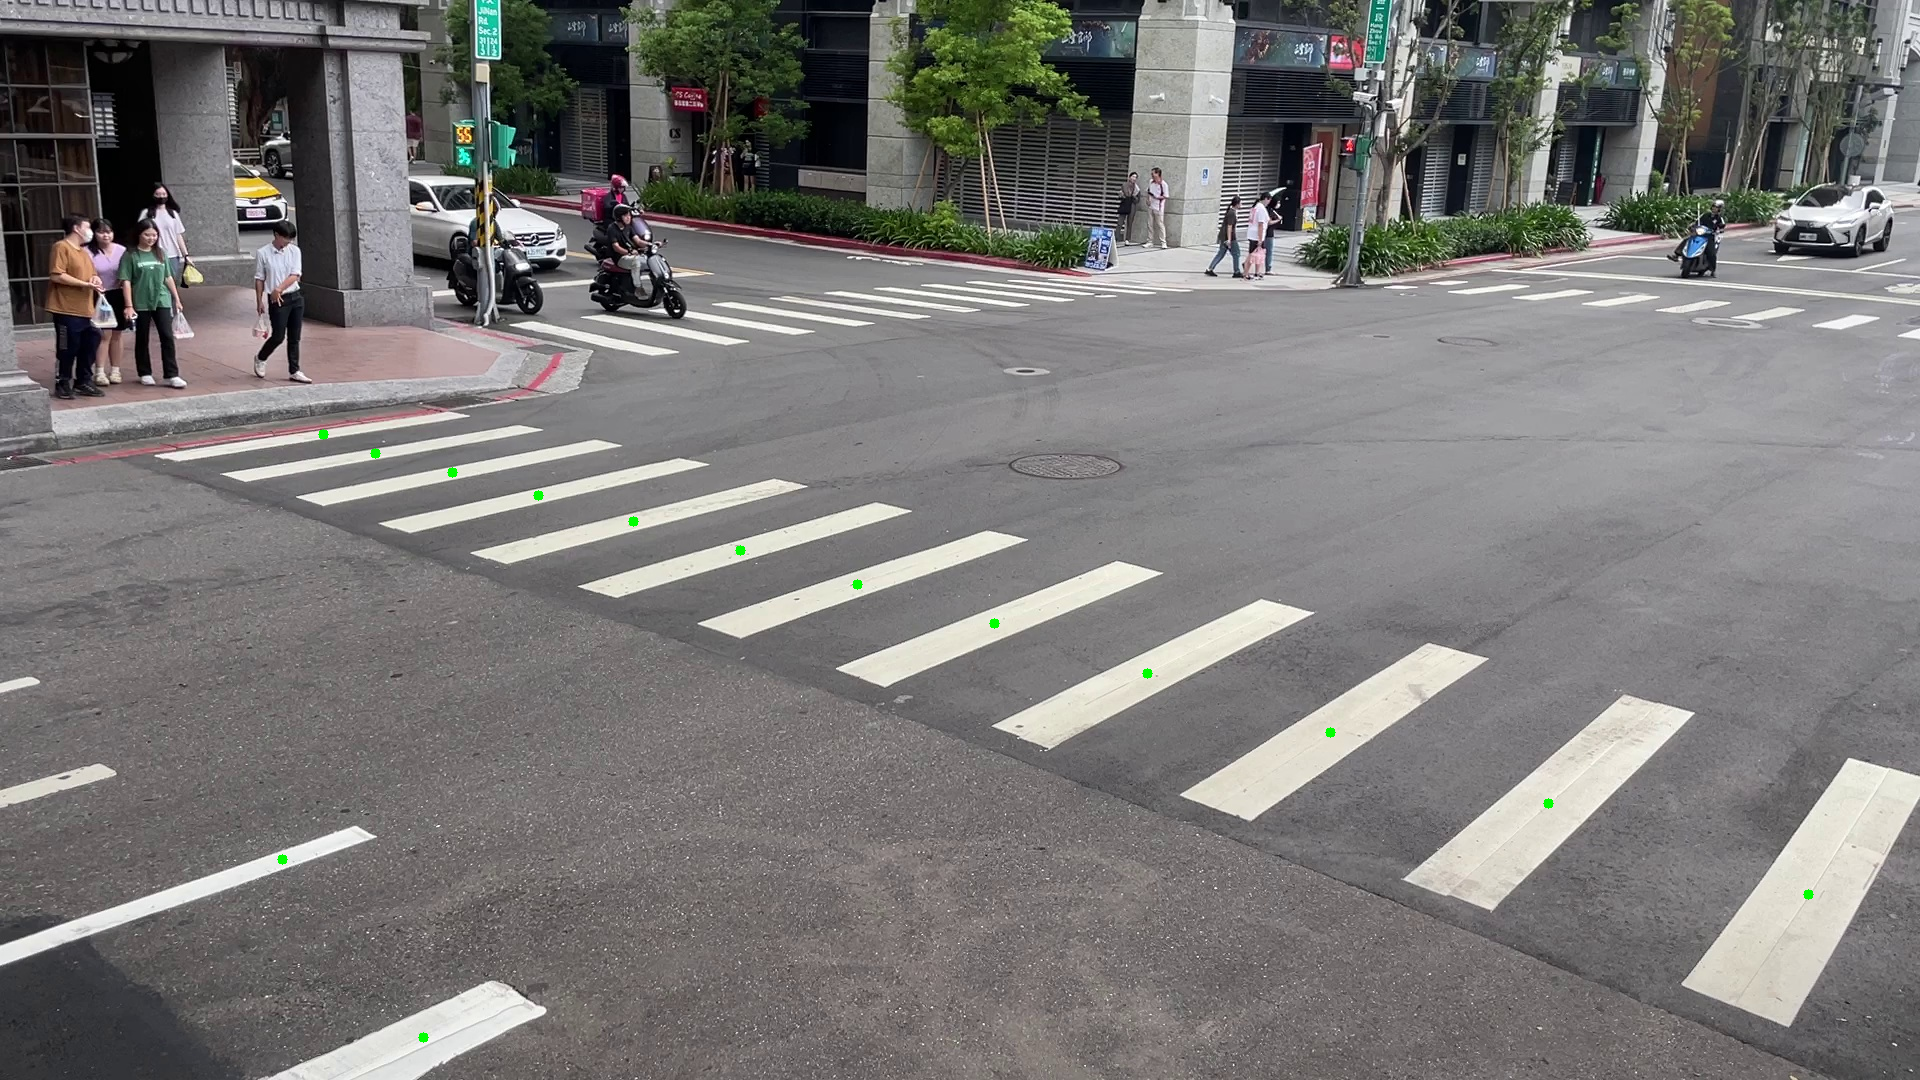

In [ ]:
ox,oy=w,h
pointx=[]
pointy=[]
for contour in contour_all:
    M = cv2.moments(contour)
    if M['m00'] != 0:
        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])
        print(cx,cy)

        slope=(cy-oy)/(cx-ox)
        print(slope)
        # 斜率大於-0.20的不要
        if slope>0.30:
          pointx.append(cx)
          pointy.append(cy)
    else:
        cx, cy = 0, 0

    # 在圖像上標記中心點
    cv2.circle(image, (cx, cy), 5, (0, 255, 0), -1)
cv2_imshow(image)

In [ ]:
import matplotlib.pyplot as plt


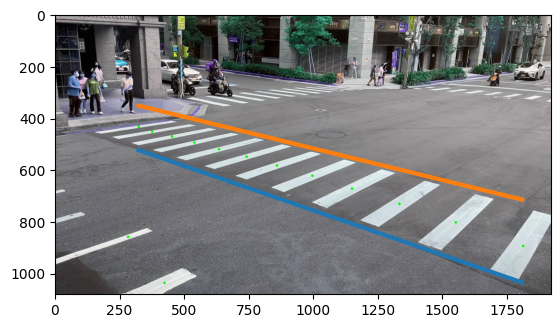

In [ ]:
# 擬合直線
#用來計算多項式的最佳擬合係數
coefficients = np.polyfit(pointx, pointy, 1)
# 提取斜率和截距
linear_fit = np.poly1d(coefficients)
slope=round(coefficients[0],3)
intercept=round(coefficients[1],3)
coefficients_one=[slope+0.04,intercept+80]
#當x等於多少的時候y等於多少

linear_fit_one = np.poly1d(coefficients_one)

coefficients_two=[slope-0.06,intercept-60]
linear_fit_two = np.poly1d(coefficients_two)
# 繪製原始點和擬合的直線
plt.imshow(image)
plt.plot(pointx, linear_fit_one(pointx), linewidth=3)  # 擬合直線
plt.plot(pointx, linear_fit_two(pointx), linewidth=3)  # 擬合直線

# 顯示圖形
plt.show()

截距大概各25

In [ ]:
print(slope)

0.305


# 三個參數(斜率,截距,行人座標)
輸入是車子座標與行人座標

low_y=-x*slope+(intercept+25)

up_y=-x*slope+(intercept-25)

In [38]:
#差放秒數
#影片擷取

from moviepy.video.io.VideoFileClip import VideoFileClip
import math
#如果人有在相片裡
#才執行主函式


#假設一秒抓一張
#time為秒數
time=1#全域變數
image_time=time
#照片會是一個資料夾image_file
image_data = {
    'people': {
        '01': [[750, 600], [20, 30], [40, 50], [60, 70]],
        '02': [[10, 20], [20, 30], [40, 50], [60, 70]]
    },
    'car': {
        '01': [[1000, 600], [20, 30], [40, 50], [60, 70]],
        '02': [[10, 20], [20, 30], [40, 50], [60, 70]]
    }
}

#資料整理
#會是所有照片的訊息 為標籤與座標
#如果照片裡面有人的標籤都在馬路上才執行違規判斷，不然就下一張





def data_sort():
  for tag ,data in image_data.items():
    print(tag)
    for data_k,data_v in data.items():
      print(data_k,data_v)
      i=0
      for coordinate in data_v:
        print(coordinate)
        if(on_crosswalk(coordinate[0],coordinate[1])):
          data_v[i]=coordinate
        else:
          data_v[i]=[]
        i+=1
      # 過濾空陣列
      image_data[tag][data_k]=[
        item for item in data_v if(item)
    ]


  print(image_data)
  rule_judge(image_data)
  clear_image_data()

#清空image_data
def clear_image_data():
  global image_data
  image_data = []

#判斷東西有沒有在馬路上的函式
#輸出會是boolean
def on_crosswalk(x,y):
    low_y=(slope-0.06)*x+(intercept-60)
    up_y=(slope+0.04)*x+(intercept+80)
    is_on_crosswalk=up_y>y>low_y

    return is_on_crosswalk

#主函式
#違規判斷

rule_id=[]#全域變數



def rule_judge(image_data_sort):
  people_data = image_data_sort['people']
  car_data = image_data_sort['car']
  for c_k, c_v in car_data.items():
    is_violation=False
    for p_v in people_data.values():
      if(is_violation):
        break
      else:
        for c_data, p_data in [[c, p] for c in c_v for p in p_v]:
          if distence_cal(c_data, p_data):
            is_violation=True
            you_violation(c_k)
            #如果違規就跳出這台車
            break





def distence_cal(car,people):
  #人在斑馬線上

  #人車都在馬路上，算距離(x差值,y差值)
  x_minus=abs(car[0]-people[0])
  y_minus=abs(car[1]-people[1])
  if(y_minus==0):
    distance=x_minus
  elif(x_minus==0):
    distance=y_minus
  else:
    distance=math.hypot(x_minus,y_minus)
  return distance>=250





#違規後續處理
def you_violation(id):
  if(id not in rule_id):
    rule_id.append(id)
    #執行影片切割

    print('違規')


# # 讀取影片
video = VideoFileClip("原影片")
#以秒數為單位
start_time=time-5
end_time=time+5

# 擷取指定範圍的影片片段與編碼格式
video_cut = video.subclip(start_time, end_time)
video_cut.write_videofile('output.mp4',codec='libx264')

data_sort()

print(rule_id)

people
01 [[750, 600], [20, 30], [40, 50], [60, 70]]
[750, 600]
[20, 30]
[40, 50]
[60, 70]
02 [[10, 20], [20, 30], [40, 50], [60, 70]]
[10, 20]
[20, 30]
[40, 50]
[60, 70]
car
01 [[1000, 600], [20, 30], [40, 50], [60, 70]]
[1000, 600]
[20, 30]
[40, 50]
[60, 70]
02 [[10, 20], [20, 30], [40, 50], [60, 70]]
[10, 20]
[20, 30]
[40, 50]
[60, 70]
{'people': {'01': [[750, 600]], '02': []}, 'car': {'01': [[1000, 600]], '02': []}}
違規
['01']
